In [69]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from datetime import timedelta
import streamlit as st
import warnings
warnings.filterwarnings('ignore')




In [70]:

# Data Loading & Preprocessing
df1 = pd.read_excel("online_retail_II.xlsx", sheet_name='Year 2009-2010', nrows=10000)
df2 = pd.read_excel("online_retail_II.xlsx", sheet_name='Year 2010-2011', nrows=10000)

df1['Year'] = '2009-2010'
df2['Year'] = '2010-2011'

df = pd.concat([df1, df2], ignore_index=True)
print("Combined shape before cleaning:", df.shape)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

df = df[~df['Invoice'].astype(str).str.startswith('C')]

df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

df['Customer ID'] = df['Customer ID'].fillna(-1)  # Use -1 to indicate unknown customer
df['Description'] = df['Description'].fillna('Unknown Product')
df['TotalAmount'] = df['Quantity'] * df['Price']

df.drop_duplicates(inplace=True)

print("Final cleaned shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print(df[['Customer ID', 'Country']].drop_duplicates().head(10))
print(df['Country'].isnull().sum())
print(df['Country'].unique())


df.head()


Combined shape before cleaning: (20000, 9)
Final cleaned shape: (19361, 10)
Missing values:
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Year           0
TotalAmount    0
dtype: int64
     Customer ID         Country
0        13085.0  United Kingdom
12       13078.0  United Kingdom
31       15362.0  United Kingdom
54       18102.0  United Kingdom
71       12682.0          France
90       18087.0  United Kingdom
96       13635.0  United Kingdom
119      14110.0  United Kingdom
126      12636.0             USA
127      17519.0  United Kingdom
0
['United Kingdom' 'France' 'USA' 'Belgium' 'Australia' 'EIRE' 'Germany'
 'Portugal' 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Norway'
 'Switzerland' 'Spain' 'Italy' 'Lithuania' 'Japan']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-2010,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-2010,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-2010,30.0


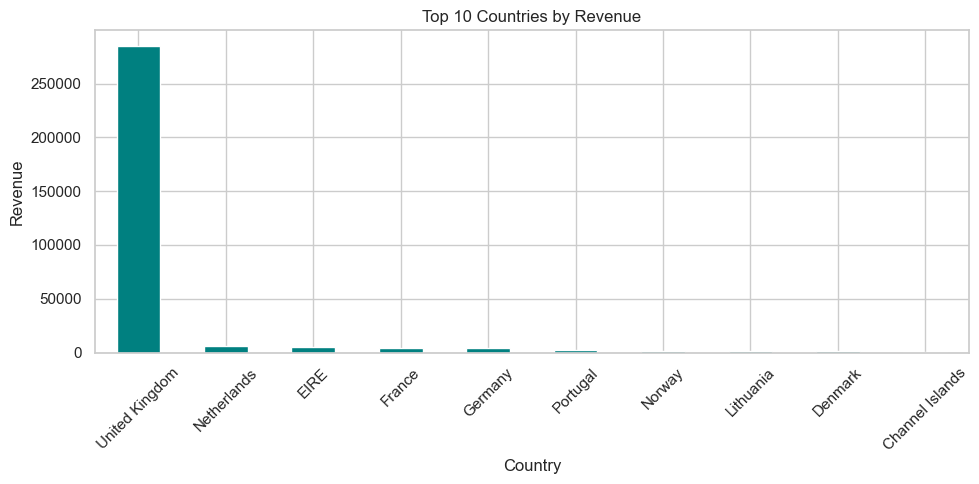

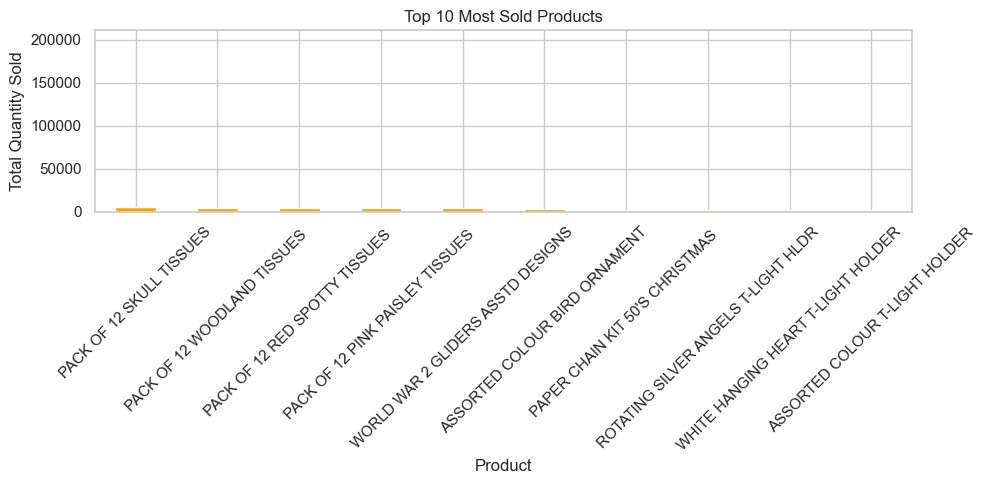

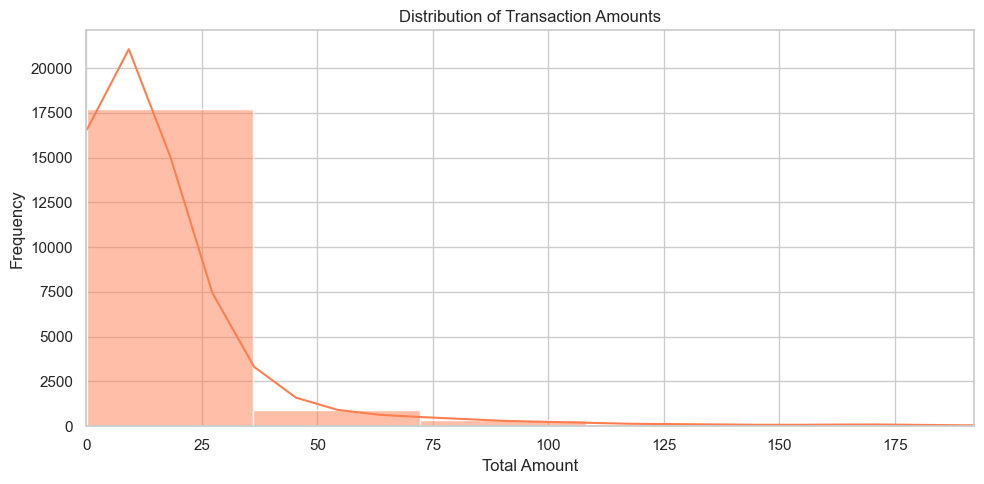

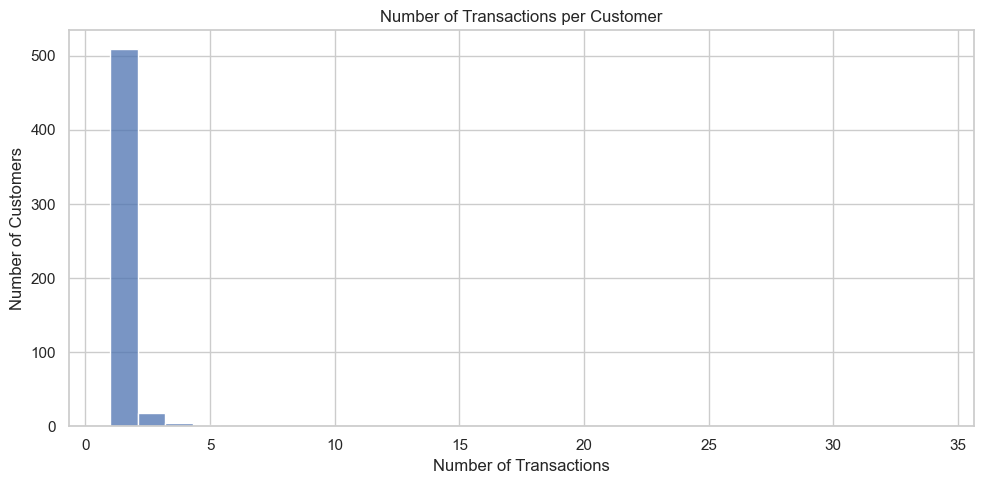

In [71]:
# Exploratory Data Analysis
# Set plot style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# 📌 1. Top Countries by Revenue

top_countries = df[df['Customer ID'] != -1].groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)
top_countries.plot(kind='bar', color='teal')
plt.title('Top 10 Countries by Revenue')
plt.ylabel('Revenue')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📌 2. Revenue Over Tim

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('InvoiceMonth')['TotalAmount'].sum()
monthly_revenue.plot(marker='o')
plt.title('Monthly Revenue Over Time')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', color='orange')
plt.title('Top 10 Most Sold Products')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Product')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📌 4. Distribution of Total Amount Spent per Transaction

sns.histplot(df['TotalAmount'], bins=50, kde=True, color='coral')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.xlim(0, df['TotalAmount'].quantile(0.99))  # limit x-axis for better view
plt.tight_layout()
plt.show()

# 📌 5. Number of Transactions per Customer

transactions_per_customer = df[df['Customer ID'] != -1].groupby('Customer ID')['Invoice'].nunique()
sns.histplot(transactions_per_customer, bins=30, kde=False)
plt.title('Number of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


In [72]:
print(df.columns)
print(df[['Country']].isnull().sum())
print([col for col in df.columns if 'country' in col.lower()])

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

customer_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'Invoice': 'nunique',                                      # Frequency
    'TotalAmount': 'sum',                                      # Monetary
    'Country': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).reset_index()

customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Country']

rfm = customer_df[customer_df['Monetary'] > 0].copy()






Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Year', 'TotalAmount',
       'InvoiceMonth'],
      dtype='object')
Country    0
dtype: int64
['Country']


In [73]:
if 'Country' in rfm.columns:
    rfm_encoded = pd.get_dummies(rfm, columns=['Country'], drop_first=True)
else:
    print("⚠️ 'Country' not found in RFM dataset.")
    rfm_encoded = rfm.copy()

print("\n🚀 Starting CLTV Modeling Pipeline...\n")

# Step 1: Split Features & Target
X = rfm_encoded.drop(columns=['Monetary'])  # Features: Recency, Frequency, Country_*
y = rfm_encoded['Monetary']                 # Target: Monetary value (proxy for CLTV)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

training_columns = X.columns.tolist()


# Step 4: Define Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Step 5: Train & Evaluate All Models
trained_models = {}
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n🔍 {name} Evaluation:")
    print("R² Score:", round(r2_score(y_test, y_pred), 4))
    print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))






🚀 Starting CLTV Modeling Pipeline...



In [74]:
# Step 6: Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb = XGBRegressor(random_state=42, verbosity=0)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("\n✅ Best XGBoost Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits

✅ Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


In [75]:
y_pred_best = best_model.predict(X_test_scaled)
print("\n📈 Tuned XGBoost Performance:")
print("R² Score:", round(r2_score(y_test, y_pred_best), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred_best), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_best)), 2))

# Step 8: Save Best Model & Scaler
import joblib
import os
os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(X_train.columns.tolist(), 'model_artifacts/feature_columns.pkl')
joblib.dump(scaler, 'model_artifacts/scaler.pkl')
joblib.dump(best_model, 'model_artifacts/model.pkl')



print("\n📦 Model and scaler saved as 'cltv_model.pkl' and 'scaler.pkl'")


📈 Tuned XGBoost Performance:
R² Score: 0.2703
MAE: 966.1
RMSE: 5614.6

📦 Model and scaler saved as 'cltv_model.pkl' and 'scaler.pkl'
